## Clairvoyance Training + Experimentation
We will be experimenting with clairvoyance training (new), while experimenting with our tabular model

In [1]:
from clairvoyance import *
from annealing import *
from functools import partial

torch.cuda.set_device(0)

In [2]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

[WindowsPath('C:/Users/dmber/.fastai/data/adult_sample/adult.csv'),
 WindowsPath('C:/Users/dmber/.fastai/data/adult_sample/adult_clairovyance.csv'),
 WindowsPath('C:/Users/dmber/.fastai/data/adult_sample/export.pkl'),
 WindowsPath('C:/Users/dmber/.fastai/data/adult_sample/models')]

In [3]:
csv_file = (path/'adult.csv')
df = pd.read_csv(csv_file)
df_clean = df.dropna().copy()
df_clean.reset_index(inplace=True)
df_clean.drop('index', axis=1, inplace=True)

In [4]:
dep_var = 'salary'
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [5]:
dataset = create_tabular_dataset(df_clean, cont_names);

In [6]:
bs = 64
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=1)

### Training our autoencoder

In [9]:
""" 
Architecture Design:
    Over Complete Sparse Autoencoder, 
    Linearly De-Scaled Complexity,
    Selu Act,

Training & Optimization:
    Ranger Optimization, 
    One Cycle Training

"""
# Hyper
alpha = 0.98  # higher than baseline
mom = 0.94    # higher than baseline
wd = 1e-4
eps = 1e-6
lr = 1e-2
sparse_reg = 1e-3
ps = 0.
encoder_type = 'over'
act = 'selu'

# model
ni, nf = get_nfs(dataloader)
nfs = [ni+1,nf+1] # less model complexity
model = create_autoencoder(dataloader, nfs, act=act, ps=ps, encoder_type=encoder_type)

# optimizer
opt_func = partial(Ranger, params=model.parameters(), betas=(mom, alpha), eps=eps, weight_decay=wd, lr=lr)
optimizer = opt_func()

# # trainiing autoencoder: Experiment with hyper above
train_sparse_autoencoder_one_cycle(dataloader, model, optimizer, max_lr=lr, num_epochs=5, sparse_reg=sparse_reg)

epoch [1/5], loss:0.0025
epoch [2/5], loss:0.0014
epoch [3/5], loss:0.0166
epoch [4/5], loss:0.0026
epoch [5/5], loss:0.0050


In [11]:
# new dataset
original_df = df_clean.copy()

In [12]:
df_final = augmented_mult(dataloader, model, original_df=original_df, dep_var=dep_var, cat_names=cat_names, mult=5)

In [14]:
final_path = (path/'adult_clairovyance.csv')
df_final.to_csv(final_path, index=False)

## Classifier BaseLine

In [3]:
from tabular import *
from annealing import *

In [4]:
df = pd.read_csv(path/'adult_clairovyance.csv') # spelled incorrect

In [5]:
' '.join(list(df.columns.values))

'age fnlwgt education-num capital-gain capital-loss hours-per-week v0 v1 v2 v3 v4 v5 v6 v7 v8 v9 v10 v11 v12 v13 v14 v15 v16 v17 v18 v19 v20 v21 v22 v23 v24 v25 v26 v27 v28 v29 v30 v31 v32 v33 v34 v35 v36 v37 v38 v39 v40 v41 v42 v43 v44 v45 v46 v47 workclass education marital-status occupation relationship race sex native-country salary'

In [6]:
def get_all_cont(df, dep_var, cat_names, original_cont):
    all_columns = list(df.columns.values)
    all_but_clairvoyance = cat_names + original_cont + [dep_var]
    
    for col in all_but_clairvoyance:
        all_columns.remove(col)
    
    return all_columns + original_cont

In [7]:
# grabbing our var names
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
original_cont = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']

cont_names = get_all_cont(df, dep_var, cat_names, original_cont)

In [8]:
# setting our procs for our databunch object
procs = [FillMissing, Categorify, Normalize]

In [9]:
def get_data(bs, path=path, cat_names=cat_names, cont_names=cont_names, dep_var=dep_var, procs=procs):
    return (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
            .split_by_rand_pct(0.1, seed=42)
            .label_from_df(cols=dep_var)
            .databunch(bs=bs, num_workers=1))

In [10]:
# use this to get new dataset for classifier
# getting data: bs = 64
bs = 64
data = get_data(bs)

In [19]:
# hyper parameters
epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

# opt, loss
optimizer = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

# model
nfs = [2000, 1000]
m = create_tabular_model(data, nfs, act='selu', emb_drop=emb_drop)

learn = (Learner(data,
                 m,
                 wd=wd,
                 opt_func=optimizer,
                 loss_func=loss_func,
                 metrics=[accuracy]
                ))
learn.to_fp16();

In [20]:
lr = 1e-4
epochs = 10
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.437461,0.432762,0.839997,00:47
1,0.431953,0.426399,0.842009,00:48
2,0.419324,0.421457,0.848673,00:50
3,0.422418,0.420360,0.850057,00:49
4,0.426601,0.419694,0.848925,00:49
5,0.416720,0.415445,0.853514,00:50
6,0.417107,0.418410,0.849051,00:49
7,0.422351,0.416778,0.850685,00:49
8,0.418133,0.414575,0.851880,00:50
9,0.422925,0.413756,0.851251,00:49


## BatchNorm Experimentation

In [55]:
#export
def tabular_bn_layer(ni, nf, act, bn_order=1):
    """
    1: after act
    2: before act
    """
    if act=='relu': act_fn = nn.ReLU(inplace=True)
    elif act=='mish': act_fn = Mish()
    elif act=='selu': act_fn = Selu()
        
    bias = False
    
    layers = [nn.Linear(ni, nf, bias=bias), act_fn, nn.BatchNorm1d(nf, eps=1e-5, momentum=0.1)] if bn_order else [nn.Linear(ni, nf, bias=bias), nn.BatchNorm1d(nf, eps=1e-5, momentum=0.1), act_fn]
    
    return nn.Sequential(*layers)

In [56]:
# hyper parameters
epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

# opt, loss
optimizer = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

# model
nfs = [500, 100]
m = create_tabular_model(data, nfs, act='mish', emb_drop=emb_drop, layer=partial(tabular_bn_layer, bn_order=0))

learn = (Learner(data,
                 m,
                 wd=wd,
                 opt_func=optimizer,
                 loss_func=loss_func,
                 metrics=[accuracy]
                ))
learn.to_fp16();

In [57]:
learn.model

Tabular(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(43, 13)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=106, out_features=500, bias=False)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=100, bias=False)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


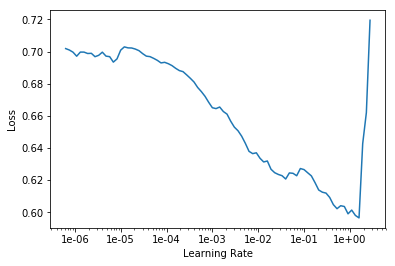

In [58]:
learn.lr_find(); learn.recorder.plot()

In [48]:
"""
act_fn = selu
lr = 1e-2
bn_order = 0

epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

"""

lr = 1e-2
epochs = 5
# fit_with_annealing(learn, epochs, lr, ann_start)
learn.fit(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.429025,0.422395,0.850308,00:55
1,0.417071,0.416490,0.851754,01:06
2,0.412448,0.413873,0.853514,00:59
3,0.419704,0.415757,0.853389,00:59
4,0.418652,0.413079,0.853326,00:54


In [ ]:
"""
nb: Train this setting for longer: 10, 20 epochs
    Reached 85.7 accuracy in 5 epochs
    Learned at a linear pace

act_fn = relu
lr = 1e-1
bn_order = 0

epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

"""

lr = 1e-1
epochs = 5
# fit_with_annealing(learn, epochs, lr, ann_start)
learn.fit_one_cycle(5, lr)

In [59]:
"""

nb: Train this setting for longer: 10, 20 epochs
    Reached 85.6 accuracy in 5 epochs
    Learned at a linear pace

act_fn = mish
lr = 1e-1
bn_order = 0

epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

"""

lr = 1e-1
epochs = 5
# fit_with_annealing(learn, epochs, lr, ann_start)
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.428279,0.417440,0.851188,00:52
1,0.424712,0.414489,0.854457,00:54
2,0.423696,0.413998,0.852760,00:59
3,0.413190,0.418700,0.852886,01:03
4,0.410891,0.409736,0.856658,00:56


### Testing withour SeLU Init

In [64]:
def init_nn(m, init_type):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0) # for batchnorm layers
    if isinstance(m, (nn.Linear)): 
        if init_type=='selu': nn.init.selu_normal_(m.weight)
        elif init_type=='kaiming_norm': nn.init.kaiming_normal_(m.weight, a=1.)
        elif init_type=='kaiming_uniform': nn.init.kaiming_uniform_(m.weight, a=1.)
    for l in m.children(): init_nn(l, init_type)

def create_tabular_model(data, nfs, layer=tabular_layer, act='relu', init_type='selu', **kwargs):
    model = Tabular(data, nfs, layer, act, **kwargs)
    init_nn(model, init_type)
    return model

In [117]:
# hyper parameters
epochs = 5
alpha = 0.99
mom = 0.95
eps = 1e-3
ann_start = 0.78
wd = 1e-4
emb_drop = 0.5

# opt, loss
optimizer = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

# model
nfs = [500, 100]
m = create_tabular_model(data, nfs, act='mish', emb_drop=emb_drop, init_type='kaiming_norm', layer=partial(tabular_bn_layer, bn_order=0))

learn = (Learner(data,
                 m,
                 wd=wd,
                 opt_func=optimizer,
                 loss_func=loss_func,
                 metrics=[accuracy]
                ))
learn.to_fp16();

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


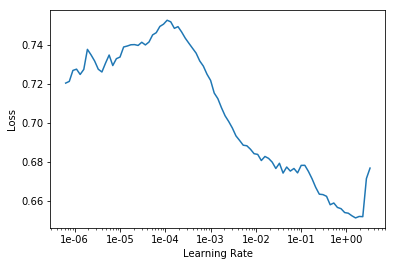

In [118]:
learn.lr_find(); learn.recorder.plot()

In [119]:
learn.model

Tabular(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(43, 13)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=106, out_features=500, bias=False)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=100, bias=False)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Mish()
    )
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [77]:
"""

nb: 

act_fn = relu
lr = 1e-1
bn_order = 0

epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

"""

lr = 1e-1
epochs = 5
# fit_with_annealing(learn, epochs, lr, ann_start)
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.428087,0.418985,0.851314,00:47
1,0.423873,0.416459,0.848233,00:48
2,0.418756,0.418129,0.853011,00:51
3,0.417623,0.415347,0.851314,00:50
4,0.405325,0.408871,0.859110,00:49


In [92]:
"""

nb: 

act_fn = mish
lr = 1e-1
bn_order = 0

epochs = 5
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

"""

lr = 1e-1
epochs = 5
# fit_with_annealing(learn, epochs, lr, ann_start)
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.417919,0.424998,0.848925,00:51
1,0.423695,0.424609,0.848171,00:52
2,0.416739,0.415067,0.852383,00:51
3,0.417132,0.418830,0.853389,00:52
4,0.416245,0.408824,0.857915,00:52


In [94]:
"""

bn: Train longer: BROKE SOTA, 86.1%

act_fn = mish
lr = 1e-1
bn_order = 0

epochs = 10
alpha = 0.97
mom = 0.93
eps = 1e-3
ann_start = 0.78
wd = 1e-5
emb_drop = 0.5

"""

lr = 1e-1
epochs = 10
# fit_with_annealing(learn, epochs, lr, ann_start)
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.427994,0.429170,0.838740,00:51
1,0.416397,0.418002,0.853263,00:49
2,0.418339,0.411480,0.857035,00:50
3,0.406817,0.413997,0.855086,00:54
4,0.412251,0.415118,0.853640,00:54
5,0.416337,0.410556,0.857538,00:50
6,0.421123,0.413795,0.856721,00:49
7,0.410597,0.410033,0.856155,00:49
8,0.410988,0.406738,0.861059,00:51
9,0.409994,0.406313,0.859927,00:50


### Experimenting with dropout

In [144]:
class Tabular(Module):
    def __init__(self, data, nfs, layer, act, ps, emb_ps, **kwargs):
        super().__init__()
        """
        Will build our model layer by layer.
        """
        # getting our embedding sizes
        # TO DO: Have this dynamic, including user input for dim sz
        self.emb_szs = data.get_emb_szs()
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in self.emb_szs])
        self.n_emb = len(self.emb_szs)

        # emb drop and encoder batchnorm
        self.n_cont = len(data.cont_names) # number of cont vars
        self.emb_drop = nn.Dropout(p=emb_ps) # TO DO: make this dynamic
        self.bn_cont = nn.BatchNorm1d(self.n_cont)
        
        self.drop = nn.Dropout(p=ps)

        # BODY: Body of the model
        # creating initial ni
            # ni = sum(emb(nf) + last_emb(ni*nf))
        ni = calc_ni_in(self.emb_szs, self.n_cont)
        self.nfs = [ni] + nfs # APPENDING

        BODY = [layer(self.nfs[i], self.nfs[i+1], act, **kwargs) for i in range(len(self.nfs)-1)]

        # HEAD: replace this for other task
        # default: classification
        HEAD = nn.Linear(nfs[-1], data.c)

        self.layers = nn.Sequential(*BODY, HEAD)

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.drop(self.layers(x))
        return x
        
def create_tabular_model(data, nfs, layer=tabular_layer, act='relu', init_type='selu', emb_ps=0., ps=0.1, **kwargs):
    model = Tabular(data, nfs, layer, act, ps, emb_ps, **kwargs)
    init_nn(model, init_type)
    return model

In [146]:
nfs = [500, 100]
m = create_tabular_model(data, nfs, act='mish', emb_ps=0.2, ps=0.1, init_type='kaiming_norm', layer=partial(tabular_bn_layer, bn_order=0))

### Testing Dropout

In [190]:
# hyper parameters
epochs = 5
alpha = 0.99
mom = 0.95
eps = 1e-3
ann_start = 0.78
wd = 1e-4
emb_ps = 0.
ps = 0.

# opt, loss
optimizer = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

# model
nfs = [500, 100]
m = create_tabular_model(data, nfs, act='mish', emb_ps=emb_ps, ps=ps, init_type='kaiming_norm', layer=partial(tabular_bn_layer, bn_order=0))

learn = (Learner(data,
                 m,
                 wd=wd,
                 opt_func=optimizer,
                 loss_func=loss_func,
                 metrics=[accuracy]
                ))
learn.to_fp16();

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


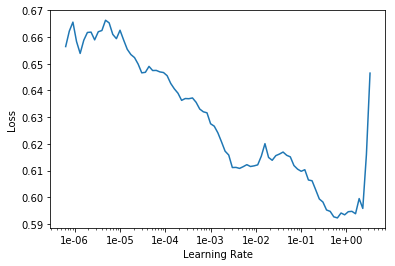

In [191]:
learn.lr_find(); learn.recorder.plot()

In [192]:
"""

bn: Train longer

act_fn = mish
lr = 1e-1
bn_order = 0

epochs = 15
alpha = 0.99
mom = 0.95
eps = 1e-3
ann_start = 0.78
wd = 1e-4
emb_ps = 0.
ps = 0.

"""

lr = 1e-1
epochs = 15
# fit_with_annealing(learn, epochs, lr, ann_start)
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.411598,0.416299,0.852949,00:50
1,0.426693,0.420799,0.851314,00:50
2,0.410951,0.414666,0.855212,00:51
3,0.416695,0.423992,0.847982,00:51
4,0.401413,0.407810,0.859738,00:51
5,0.414087,0.408680,0.860179,01:01
6,0.407666,0.412474,0.858795,01:02
7,0.402524,0.405750,0.858481,00:58
8,0.409541,0.407583,0.861247,00:57
9,0.405005,0.412390,0.858041,00:52


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


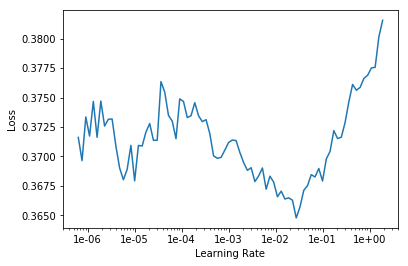

In [194]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

In [195]:
learn.save('m1_frozen')

In [196]:
lr = 1e-2
epochs = 5
# fit_with_annealing(learn, epochs, lr, ann_start)
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,time
0,0.379614,0.385724,0.871244,00:49
1,0.376971,0.386232,0.872187,00:51
2,0.365945,0.385894,0.873884,00:52
3,0.374200,0.385068,0.872312,00:52
4,0.369349,0.381790,0.873884,00:54
